# Building a Bayesian Multi-armed Bandit to Choose An Article Title 

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# Between what options we choose.
TITLE_OPTION_ONE = 'Title Option One'
TITLE_OPTION_TWO = 'Title Option Two'

# "Real" CTRs that are not known for the bandit.
# We need them to simulate viewers behavior.
OPTION_ONE_POPULATION_CLICK_THROUGH_RATE = 0.05
OPTION_TWO_POPULATION_CLICK_THROUGH_RATE = 0.07

# Number of visitors whom we will show titles.
VISITORS_CNT = 1000

# Our prior belief about CTRs.
# Using a=1 and b=1 we state that there are no beliefs, any CTR is equally probable.
PRIOR_A = 1
PRIOR_B = 1

In [3]:
# To replicate results
np.random.seed(20231119)

# Variables to track how many viewers have seen a title and then clicked on it.
title_one_seen = 0
title_one_clicked = 0

title_two_seen = 0
title_two_clicked = 0

# These arrays are needed to evaluate performance of algorithms later on
bandit_visitors_seen_highest_ctr_title = []
random_visitors_seen_highest_ctr_title = []

# For each visitor...
for _ in range(VISITORS_CNT):
    # ... generate a posterior using Beta distribution adjusted based on observed data ...
    option_one_beta_distribution = stats.beta(
        a=PRIOR_A + title_one_clicked, # Add number of "clicks"
        b=PRIOR_B + (title_one_seen - title_one_clicked) # Add number of "skips"
    )

    option_two_beta_distribution = stats.beta(
        a=PRIOR_A + title_two_clicked, # Adjusted based on observed data
        b=PRIOR_B + (title_two_seen - title_two_clicked) # Adjusted based on observed data
    )

     # ... sample CTRs from these distirbutions ... 
    title_one_sample_ctr = option_one_beta_distribution.rvs()
    title_two_sample_ctr = option_two_beta_distribution.rvs()

    # ... choose what title to show using Thompson sampling.
    if title_one_sample_ctr >= title_two_sample_ctr:
        # Show title 1
        title_one_seen += 1
        # We know that title one has lower CTR. Hence, algorithm made a mistake.
        bandit_visitors_seen_highest_ctr_title.append(0)

        # Determine if visitor has clicked on the title.
        if np.random.uniform(0.0, 1.0) <= OPTION_ONE_POPULATION_CLICK_THROUGH_RATE:
            title_one_clicked += 1

    else:
        # Show title 2
        title_two_seen += 1
        # We know that title two has higher CTR. Hence, algorithm made a correct decision.
        bandit_visitors_seen_highest_ctr_title.append(1)

        # Determine if visitor has clicked
        if np.random.uniform(0.0, 1.0) <= OPTION_TWO_POPULATION_CLICK_THROUGH_RATE:
            title_two_clicked += 1

    # Our alternative to a Bayesian Multi-armed Bandit is a random split between both options
    # Split is 50/50, which is why with probability of 0.5 random will asign the higher CTR title.
    if np.random.uniform(0.0, 1.0) <= 0.5:
        random_visitors_seen_highest_ctr_title.append(1)
    else:
        random_visitors_seen_highest_ctr_title.append(0)

print('RESULTS OF THE SIMULATION')
print('Viewers seen title one', title_one_seen)
print('Viewers clicked on title one', title_one_clicked)
print('Observed CTR of title one', title_one_clicked / title_one_seen)

print()

print('RESULTS OF THE SIMULATION')
print('Viewers seen title two', title_two_seen)
print('Viewers clicked on title two', title_two_clicked)
print('Observed CTR of title two', title_two_clicked / title_two_seen)

print()

print('% of viewers whom Multi-armed Bandit showed the highest CTR title', np.mean(bandit_visitors_seen_highest_ctr_title))
print('% of viewers whom Random Split showed the highest CTR title', np.mean(random_visitors_seen_highest_ctr_title))

RESULTS OF THE SIMULATION
Viewers seen title one 227
Viewers clicked on title one 10
Observed CTR of title one 0.04405286343612335

RESULTS OF THE SIMULATION
Viewers seen title two 773
Viewers clicked on title two 54
Observed CTR of title two 0.06985769728331177

% of viewers whom Multi-armed Bandit showed the highest CTR title 0.773
% of viewers whom Random Split showed the highest CTR title 0.502


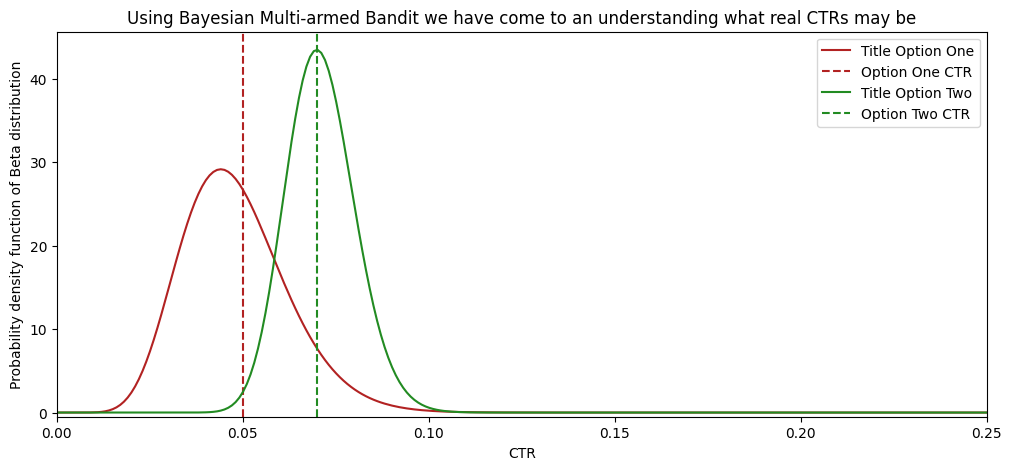

In [4]:
option_one_beta_distribution = stats.beta(
    a=PRIOR_A + title_one_clicked, 
    b=PRIOR_B + (title_one_seen - title_one_clicked)
)

option_two_beta_distribution = stats.beta(
    a=PRIOR_A + title_two_clicked, 
    b=PRIOR_B + (title_two_seen - title_two_clicked)
)

x = np.linspace(0.0, 1.0, 1000)

plt.figure(figsize=(12, 5))

plt.plot(x, 
         option_one_beta_distribution.pdf(x), 
         label=TITLE_OPTION_ONE, 
         color='firebrick')

plt.axvline(OPTION_ONE_POPULATION_CLICK_THROUGH_RATE, 
            label='Option One CTR',
            ls='--',
            color='firebrick')

plt.plot(x, 
         option_two_beta_distribution.pdf(x), 
         label=TITLE_OPTION_TWO, 
         color='forestgreen')

plt.axvline(OPTION_TWO_POPULATION_CLICK_THROUGH_RATE, 
            label='Option Two CTR',
            ls='--',
            color='forestgreen')

plt.xlim(0.0, 0.25)
plt.ylim(0.0 - 5e-1)

plt.ylabel('Probability density function of Beta distribution')
plt.xlabel('CTR')

plt.title('Using Bayesian Multi-armed Bandit we have come to an understanding what real CTRs may be')

plt.legend()

plt.savefig('./output/estimated-ctr-pdfs.png', bbox_inches='tight', dpi=100)

plt.show()

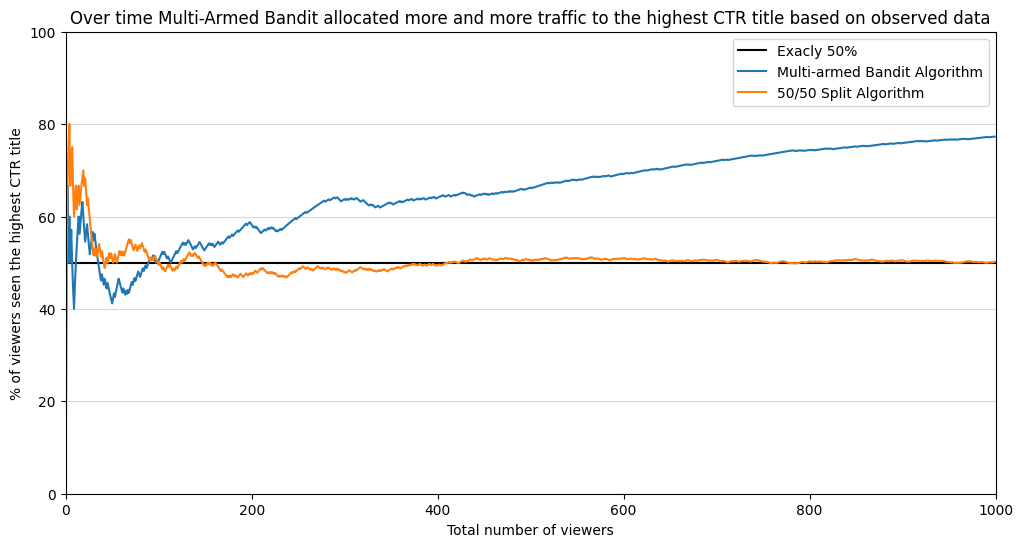

In [5]:
plt.figure(figsize=(12, 6))

plt.axhline(50.0, color='black', label='Exacly 50%')

plt.plot(
    range(len(bandit_visitors_seen_highest_ctr_title)), 
    100.0 * np.cumsum(bandit_visitors_seen_highest_ctr_title) / np.cumsum(np.ones(len(bandit_visitors_seen_highest_ctr_title))),
    label='Multi-armed Bandit Algorithm'
)

plt.plot(
    range(len(random_visitors_seen_highest_ctr_title)), 
    100.0 * np.cumsum(random_visitors_seen_highest_ctr_title) / np.cumsum(np.ones(len(random_visitors_seen_highest_ctr_title))),
    label='50/50 Split Algorithm'
)

plt.ylabel('% of viewers seen the highest CTR title')
plt.ylim(0.0, 100.0)

plt.xlabel('Total number of viewers')
plt.xlim(0, len(random_visitors_seen_highest_ctr_title))

plt.title('Over time Multi-Armed Bandit allocated more and more traffic to the highest CTR title based on observed data')

plt.legend()

plt.grid(axis='y', color='black', alpha=0.15)

plt.savefig('./output/share-seen-highest-ctr.png', bbox_inches='tight', dpi=100)

plt.show()

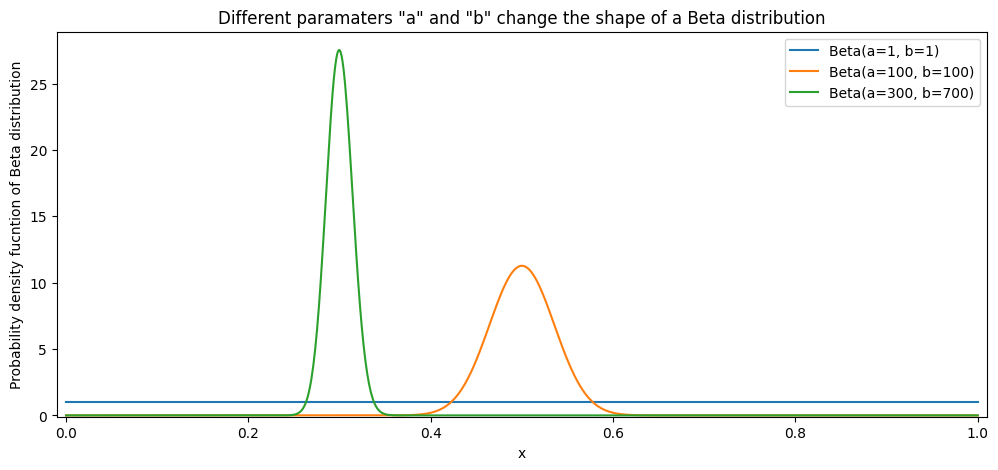

In [6]:
def plot_beta(a, b):
    plt.plot(x, stats.beta(a=a, b=b).pdf(x), label=f'Beta(a={a}, b={b})')
    plt.legend()

plt.figure(figsize=(12, 5))

plot_beta(1, 1)
plot_beta(100, 100)
plot_beta(300, 700)

plt.xlim(0-1e-2, 1+1e-2)
plt.ylim(0-1e-1)

plt.xlabel('x')
plt.ylabel('Probability density fucntion of Beta distribution')

plt.title('Different paramaters "a" and "b" change the shape of a Beta distribution')

plt.savefig('./output/beta-distr-examples.png', bbox_inches='tight', dpi=100)

plt.show()